# 1. Classification
Classification algorithms in PySpark require labels to be numeric. String labels can be transformed into float using the 
<code style='font-size:13px;'>StringIndexer()</code>
function or using mapping technique. In binary classification, label 1 is treated as the positive class.

In [1]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel
from pyspark.ml.classification import MultilayerPerceptronClassifier, MultilayerPerceptronClassificationModel

import numpy as np
import pandas as pd

In [5]:
dfIris = spark.read.csv('data/iris.csv', header=True, inferSchema=True)
indexer = StringIndexer(inputCol='species', outputCol='species_index')
dfIris = indexer.fit(dfIris).transform(dfIris)
dfIris.limit(5)

sepal_length,sepal_width,petal_length,petal_width,species,species_index
5.1,3.5,1.4,0.2,setosa,0.0
4.9,3.0,1.4,0.2,setosa,0.0
4.7,3.2,1.3,0.2,setosa,0.0
4.6,3.1,1.5,0.2,setosa,0.0
5.0,3.6,1.4,0.2,setosa,0.0


In [3]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
assembler = VectorAssembler(inputCols=features, outputCol='features')

dfIris = assembler.transform(dfIris)
dfIris = dfIris.selectExpr('features', 'species_index AS label')
dfIris.limit(5)

features,label
[5.09999990463256...,0.0
[4.90000009536743...,0.0
[4.69999980926513...,0.0
[4.59999990463256...,0.0
"[5.0,3.5999999046...",0.0


In [4]:
dfIrisTrain, dfIrisTest = dfIris.randomSplit([0.8, 0.2], seed=5)

### Naive Bayes
[Naive Bayes classification](https://spark.apache.org/docs/latest/ml-classification-regression.html#naive-bayes) is a family of simple probabilistic, multiclass classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between every pair of features.

In [5]:
bayes = NaiveBayes(
    modelType='gaussian',
    smoothing=0.1
)

model = bayes.fit(dfIrisTrain)

In [6]:
dfIrisPredict = model.transform(dfIrisTest)
dfIrisPredict.limit(5)

features,label,rawPrediction,probability,prediction
[4.59999990463256...,0.0,[4.11081256251336...,"[1.0,4.5682062915...",0.0
"[5.0,3.2999999523...",0.0,[4.69678632396601...,"[1.0,1.2333989906...",0.0
"[5.0,3.5999999046...",0.0,[4.60606070445828...,"[1.0,1.3255041009...",0.0
[5.19999980926513...,0.0,[2.06201152614811...,"[1.0,8.6079890489...",0.0
[5.40000009536743...,0.0,[3.85935042111834...,"[1.0,8.7870105216...",0.0


In [7]:
getItem = F.udf(lambda col: float(col[0]), T.FloatType())
dfIrisPredict.select(getItem('probability')).limit(5)

<lambda>(probability)
1.0
1.0
1.0
1.0
1.0


### Logistic Regression
[Logistic Regression](https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression) is a popular method to predict a categorical response.

In [8]:
logistic = LogisticRegression(
    elasticNetParam=0.5,
    regParam=0.1
)

model = logistic.fit(dfIrisTrain)

In [9]:
dfIrisPredict = model.transform(dfIrisTest)
dfIrisPredict.limit(5)

features,label,rawPrediction,probability,prediction
[4.59999990463256...,0.0,[2.11777964128874...,[0.86270648434772...,0.0
"[5.0,3.2999999523...",0.0,[2.01546198803795...,[0.84580574303289...,0.0
"[5.0,3.5999999046...",0.0,[2.26626426475033...,[0.88805604538443...,0.0
[5.19999980926513...,0.0,[2.67738960744594...,[0.93589969409573...,0.0
[5.40000009536743...,0.0,[2.20083593390341...,[0.88455758657283...,0.0


### Decision Tree
[Decision Tree](https://spark.apache.org/docs/latest/mllib-decision-tree.html) is a popular family of classification and regression methods.

In [10]:
tree = DecisionTreeClassifier(
    impurity='entropy',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
)
model = tree.fit(dfIrisTrain)

### Random Forest
[Random Forest](https://spark.apache.org/docs/latest/mllib-ensembles.html#random-forests) is a popular algorithm of the tree based family.

In [11]:
forest = RandomForestClassifier(
    impurity='entropy',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    numTrees=32,
    featureSubsetStrategy='sqrt',
    subsamplingRate=0.8
)
model = forest.fit(dfIrisTrain)

### Gradient Boosted Trees
[Gradient Boosted Tree](https://spark.apache.org/docs/latest/mllib-ensembles.html#gradient-boosted-trees-gbts) in PySpark currently only supports binary classification.

In [12]:
gbt = GBTClassifier(
    impurity='variance',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    lossType='logistic',
    stepSize=0.1,
    featureSubsetStrategy='all'
)
model = gbt.fit(dfIrisTrain.filter('label IN (0.0, 1.0)'))

### Multilayer Perceptron
[MLP](https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier) is a classifier based on the feedforward artificial neural network.

In [13]:
mlp = MultilayerPerceptronClassifier(
    layers=[4, 20, 10, 3],
    stepSize=0.03,
    tol=1e-6,
    solver='l-bfgs'
)
model = mlp.fit(dfIrisTrain)

# 2. Regression

In [14]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.regression import GBTRegressor, GBTRegressionModel

import numpy as np
import pandas as pd

In [15]:
dfBoston = spark.read.csv('data/boston.csv', header=True, inferSchema=True)
dfBoston.limit(5)

crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2


In [16]:
features = dfBoston.columns[:-1]
assembler = VectorAssembler(inputCols=features, outputCol='features')

dfBoston = assembler.transform(dfBoston)
dfBoston = dfBoston.selectExpr('features', 'price AS label')
dfBoston.limit(5)

features,label
[0.00632000016048...,24.0
[0.02731000073254...,21.6
[0.02728999964892...,34.7
[0.03237000107765...,33.4
[0.06904999911785...,36.2


In [17]:
dfBostonTrain, dfBostonTest = dfBoston.randomSplit([0.8, 0.2], seed=7)

### Linear Regression
The interface for working with [Linear Regression](https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression) models and model summaries is similar to the logistic regression case

In [18]:
linear = LinearRegression(
    elasticNetParam=0.5,
    regParam=1e-2
)

model = linear.fit(dfBostonTrain)

In [19]:
model.transform(dfBostonTest).limit(5)

features,label,prediction
[0.01360000018030...,18.9,16.284435700454623
[0.01432000007480...,31.6,34.06102709920108
[0.01501000020653...,24.5,28.233316931571785
[0.01501000020653...,50.0,44.10315078135267
[0.01869999989867...,23.1,26.167508650667223


### Random Forest
[Random Forest](https://spark.apache.org/docs/latest/mllib-ensembles.html#random-forests) is a popular algorithm of the tree based family.

In [20]:
forest = RandomForestRegressor(
    impurity='variance',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    numTrees=32,
    featureSubsetStrategy='sqrt',
    subsamplingRate=0.8
)
model = forest.fit(dfBostonTrain)

### Gradient Boosted Trees
[Gradient Boosted Tree](https://spark.apache.org/docs/latest/mllib-ensembles.html#gradient-boosted-trees-gbts) is an ensemble of Decision Trees.

In [21]:
gbt = GBTRegressor(    
    impurity='variance',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    lossType='squared',
    stepSize=0.1,
    featureSubsetStrategy='all'
)
model = gbt.fit(dfBostonTrain)

# 3. Working on models

## 3.1. Evaluation

In [22]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel
from pyspark.ml.regression import GBTRegressor, GBTRegressionModel

import numpy as np
import pandas as pd

In [23]:
dfIris = spark.read.csv('data/iris.csv', header=True)
for i in ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']:
    dfIris = dfIris.withColumn(i, F.col(i).cast('float'))
indexer = StringIndexer(inputCol='species', outputCol='species_index')
dfIris = indexer.fit(dfIris).transform(dfIris)
dfIris.limit(5)

sepal_length,sepal_width,petal_length,petal_width,species,species_index
5.1,3.5,1.4,0.2,setosa,0.0
4.9,3.0,1.4,0.2,setosa,0.0
4.7,3.2,1.3,0.2,setosa,0.0
4.6,3.1,1.5,0.2,setosa,0.0
5.0,3.6,1.4,0.2,setosa,0.0


In [24]:
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
assembler = VectorAssembler(inputCols=features, outputCol='features')

dfIris = assembler.transform(dfIris)
dfIris = dfIris.selectExpr('features', 'CAST(species_index AS int) AS label')
dfIrisTrain, dfIrisTest = dfIris.randomSplit([0.8, 0.2], seed=15)

In [25]:
dfBoston = spark.read.csv('data/boston.csv', header=True)
dfBoston = dfBoston.select([F.col(c).cast('float') for c in dfBoston.columns])
dfBoston.limit(5)

crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2


In [26]:
features = dfBoston.columns[:-1]
assembler = VectorAssembler(inputCols=features, outputCol='features')

dfBoston = assembler.transform(dfBoston)
dfBoston = dfBoston.selectExpr('features', 'price AS label')
dfBostonTrain, dfBostonTest = dfBoston.randomSplit([0.8, 0.2], seed=7)

### Binary classification

In [27]:
gbt = GBTClassifier(
    impurity='variance',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    lossType='logistic',
    stepSize=0.1,
    featureSubsetStrategy='all'
)
model = gbt.fit(dfIrisTrain.filter('label IN (0.0, 1.0)'))

In [28]:
dfIrisPredictTrain = model.transform(dfIrisTrain.filter('label IN (0.0, 1.0)'))
dfIrisPredictTest = model.transform(dfIrisTest.filter('label IN (0.0, 1.0)'))

In [29]:
evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

auroc_train = evaluator.evaluate(dfIrisPredictTrain)
auroc_test = evaluator.evaluate(dfIrisPredictTest)
print(f'AUROC train = {auroc_train}')
print(f'AUROC test = {auroc_test}')

AUROC train = 1.0
AUROC test = 1.0


In [30]:
evaluator = BinaryClassificationEvaluator()

auprc_train = evaluator.setMetricName('areaUnderPR').evaluate(dfIrisPredictTrain)
auprc_test = evaluator.evaluate(dfIrisPredictTest, {evaluator.metricName: 'areaUnderPR'})
print(f'AUPRC train = {auprc_train}')
print(f'AUPRC test = {auprc_test}')

AUPRC train = 1.0
AUPRC test = 1.0


### Multi-class classification

In [31]:
forest = RandomForestClassifier(
    impurity='entropy',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    numTrees=32,
    featureSubsetStrategy='sqrt',
    subsamplingRate=0.8
)
model = forest.fit(dfIrisTrain)

In [32]:
dfIrisPredictTrain = model.transform(dfIrisTrain)
dfIrisPredictTest = model.transform(dfIrisTest)

In [33]:
evaluator = MulticlassClassificationEvaluator(metricName='accuracy')

accuracy_train = evaluator.evaluate(dfIrisPredictTrain)
accuracy_test = evaluator.evaluate(dfIrisPredictTest)
print(f'Accuracy train = {accuracy_train}')
print(f'Accuracy test = {accuracy_test}')

Accuracy train = 0.9478260869565217
Accuracy test = 0.9714285714285714


In [34]:
evaluator = MulticlassClassificationEvaluator(metricName='weightedFMeasure', beta=4)

f4_train = evaluator.evaluate(dfIrisPredictTrain)
f4_test = evaluator.evaluate(dfIrisPredictTest)
print(f'F4-score train = {f4_train}')
print(f'F4-score test = {f4_test}')

F4-score train = 0.9478260869565217
F4-score test = 0.9713433491477772


### Regression

In [35]:
gbt = GBTRegressor(
    impurity='variance',
    maxDepth=8,
    maxBins=16,
    minInstancesPerNode=10,
    minInfoGain=0.1,
    minWeightFractionPerNode=0.2,
    
    lossType='squared',
    stepSize=0.1,
    featureSubsetStrategy='all'
)
model = gbt.fit(dfBostonTrain)

In [36]:
dfBostonPredictTrain = model.transform(dfBostonTrain)
dfBostonPredictTest = model.transform(dfBostonTest)

In [37]:
evaluator = RegressionEvaluator(metricName='rmse')

rmse_train = evaluator.evaluate(dfBostonPredictTrain)
rmse_test = evaluator.evaluate(dfBostonPredictTest)
print(f'RMSE train = {rmse_train}')
print(f'RMSE test = {rmse_test}')

RMSE train = 5.044324688802385
RMSE test = 5.500462347367838


In [38]:
evaluator = RegressionEvaluator(metricName='r2')

r2_train = evaluator.evaluate(dfBostonPredictTrain)
r2_test = evaluator.evaluate(dfBostonPredictTest)
print(f'R2 train = {r2_train}')
print(f'R2 test = {r2_test}')

R2 train = 0.6996784601585035
R2 test = 0.6348969845155188


## 3.2. Tuning

In [39]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.regression import GBTRegressor, GBTRegressionModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import numpy as np
import pandas as pd

In [40]:
dfBoston = spark.read.csv('data/boston.csv', header=True)
dfBoston = dfBoston.select([F.col(c).cast('float') for c in dfBoston.columns])
dfBoston.limit(5)

crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2


In [41]:
features = dfBoston.columns[:-1]
assembler = VectorAssembler(inputCols=features, outputCol='features')

dfBoston = assembler.transform(dfBoston)
dfBoston = dfBoston.selectExpr('features', 'price AS label')
dfBostonTrain, dfBostonTest = dfBoston.randomSplit([0.8, 0.2], seed=7)

### Tuning Random Forest

In [42]:
forest = RandomForestRegressor()

paramGrid = ParamGridBuilder()\
    .addGrid(forest.numTrees, [32, 64])\
    .addGrid(forest.minInstancesPerNode, [5])\
    .addGrid(forest.featureSubsetStrategy, ['onethird', 'sqrt', 'log2'])\
    .addGrid(forest.maxDepth, [4, 8])\
    .addGrid(forest.subsamplingRate, [0.3, 0.5, 0.7])\
    .build()

evaluator = RegressionEvaluator(metricName='rmse')

In [43]:
cv = CrossValidator(estimator=forest, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvModel = cv.fit(dfBostonTrain)

In [44]:
cvModel.bestModel.getNumTrees

64

In [45]:
cvModel.bestModel.getMaxDepth()

8

In [46]:
cvModel.bestModel.getSubsamplingRate()

0.7

In [47]:
cvModel.bestModel.getFeatureSubsetStrategy()

'onethird'

In [48]:
dfBostonPredictTrain = cvModel.transform(dfBostonTrain)
dfBostonPredictTest = cvModel.transform(dfBostonTest)

In [49]:
evaluator = RegressionEvaluator(metricName='rmse')

rmse_train = evaluator.evaluate(dfBostonPredictTrain)
rmse_test = evaluator.evaluate(dfBostonPredictTest)
print(f'RMSE train = {rmse_train}')
print(f'RMSE test = {rmse_test}')

RMSE train = 3.0187282727825355
RMSE test = 3.3801446043211554


### Tuning Gradient Boosted Trees

In [50]:
gbt = GBTRegressor()

paramGrid = ParamGridBuilder()\
    .addGrid(gbt.minInstancesPerNode, [10])\
    .addGrid(gbt.featureSubsetStrategy, ['onethird', 'sqrt', 'log2'])\
    .addGrid(gbt.stepSize, [0.05, 0.1, 0.15, 0.2, 0.25])\
    .build()

evaluator = RegressionEvaluator(metricName='rmse')

In [51]:
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvModel = cv.fit(dfBostonTrain)

In [52]:
cvModel.bestModel.getFeatureSubsetStrategy()

'sqrt'

In [53]:
cvModel.bestModel.getStepSize()

0.2

In [54]:
dfBostonPredictTrain = cvModel.transform(dfBostonTrain)
dfBostonPredictTest = cvModel.transform(dfBostonTest)

In [55]:
evaluator = RegressionEvaluator(metricName='rmse')

rmse_train = evaluator.evaluate(dfBostonPredictTrain)
rmse_test = evaluator.evaluate(dfBostonPredictTest)
print(f'RMSE train = {rmse_train}')
print(f'RMSE test = {rmse_test}')

RMSE train = 1.8478622428230596
RMSE test = 3.5880572581783126


## 3.3. Micellaneous techniques

In [56]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel

import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'

In [57]:
dfBoston = spark.read.csv('data/boston.csv', header=True)
dfBoston = dfBoston.select([F.col(c).cast('float') for c in dfBoston.columns])
dfBoston.limit(5)

crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2


In [58]:
features = dfBoston.columns[:-1]
assembler = VectorAssembler(inputCols=features, outputCol='features')

dfBoston = assembler.transform(dfBoston)
dfBoston = dfBoston.selectExpr('features', 'price AS label')
dfBostonTrain, dfBostonTest = dfBoston.randomSplit([0.8, 0.2], seed=7)

In [59]:
forest = RandomForestRegressor(
    impurity='variance',
    maxDepth=8,
    maxBins=32,
    minInstancesPerNode=5,
    minInfoGain=0.0,
    minWeightFractionPerNode=0.0,
    
    numTrees=64,
    featureSubsetStrategy='onethird',
    subsamplingRate=0.7
)
model = forest.fit(dfBostonTrain)

### Saving and load a model

In [60]:
model.save('rf_model.model')

In [61]:
RandomForestRegressionModel().load('rf_model.model')

RandomForestRegressionModel: uid=RandomForestRegressor_0efc6b26fc6f, numTrees=64, numFeatures=13

### Feature importances

In [62]:
dfBostonTrain.columns

['features', 'label']

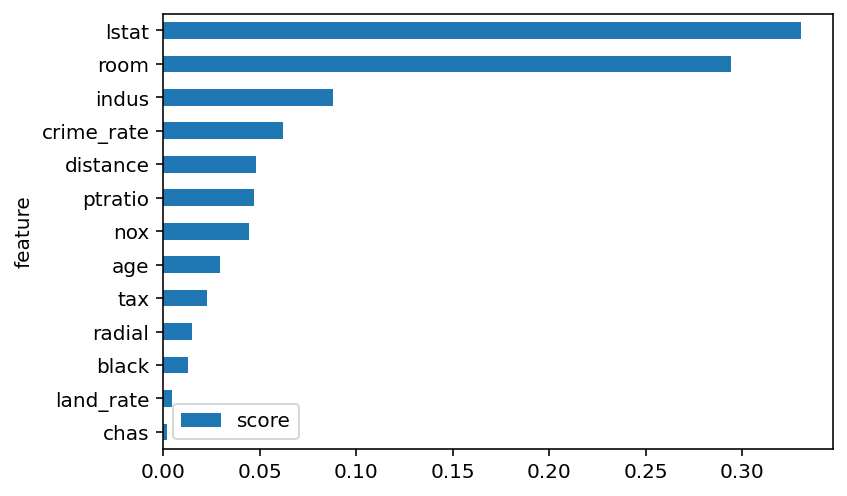

In [63]:
df = pd.DataFrame({
    'feature': features,
    'score': model.featureImportances.values
})

df\
    .sort_values('score')\
    .plot(x='feature', y='score', kind='barh', sort_columns='score');

### ML Pipelines

[ML pipelines](https://spark.apache.org/docs/latest/ml-pipeline.html) in pyspark is insprired by pipelines in sklearn. 

In [18]:
import findspark; findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import MinMaxScaler, Imputer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

%config InlineBackend.figure_format = 'retina'

In [67]:
boston = spark.read.csv('data/boston.csv', header=True)
boston = boston.select([F.col(c).cast('float') for c in boston.columns])
boston.limit(5)

crime_rate,land_rate,indus,chas,nox,room,age,distance,radial,tax,ptratio,black,lstat,price
0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98,24.0
0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.9,9.14,21.6
0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.9,5.33,36.2


In [68]:
features = boston.columns[:-1]
assembler = VectorAssembler(inputCols=features, outputCol='features')
boston = assembler.transform(boston)

boston = boston.selectExpr('features', 'price AS label')
boston_train, boston_test = boston.randomSplit([0.8, 0.2], seed=7)

In [69]:
pca = PCA(k=3, inputCol='features')
scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeature')
pipeline = Pipeline(stages=[pca,scaler])

In [70]:
process = pipeline.fit(boston_train)

In [71]:
process.stages

[PCAModel: uid=PCA_9cea4e1d9774, k=3,
 MinMaxScalerModel: uid=MinMaxScaler_a1f9dfe4b73c, numFeatures=13, min=0.0, max=1.0]

In [72]:
scaled_train = process.transform(boston_train)
scaled_test = process.transform(boston_test)

In [73]:
# using with grid-search
forest = RandomForestRegressor()
evaluator = RegressionEvaluator(metricName='rmse')

paramGrid = ParamGridBuilder()\
    .addGrid(forest.numTrees, [32, 64])\
    .addGrid(forest.featureSubsetStrategy, ['onethird', 'sqrt', 'log2'])\
    .addGrid(forest.maxDepth, [4, 8])\
    .build()

In [74]:
cv = CrossValidator(estimator=forest, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvModel = cv.fit(scaled_train)

In [75]:
predictor_train = cvModel.transform(scaled_train)
predictor_test = cvModel.transform(scaled_test)

In [76]:
rmse_train = evaluator.evaluate(predictor_train)
rmse_test = evaluator.evaluate(predictor_test)
print(f'RMSE train = {rmse_train}')
print(f'RMSE test = {rmse_test}')

RMSE train = 1.8285238279482803
RMSE test = 3.0666129101897193


---
*&#9829; By Quang Hung x Thuy Linh &#9829;*